## Map Control Visualization Notebook

Hi! This is my first notebook on my attempt to quantify/visualize map control. Even though this work is specifically on CS:GO, I'm sure it can be adapted for other games, either FPS or not.

### Import Libraries

In [1]:
import pandas as pd

from csgo.parser import DemoParser
import time
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import patches
import imageio

### Load In Demo Data

In [10]:
# Create the parser object.
# Set log=True above if you want to produce a logfile for the parser.

# The JSON for this game is in the repo. The following two links are the 
# demos I've been using for Dust2 [Endpoint v CPH] and Inferno [2018 Boston Major Faze v c9] (respectively)
# https://www.hltv.org/matches/2352373/endpoint-vs-copenhagen-flames-esea-premier-season-38-europe-relegation
# https://www.hltv.org/stats/matches/mapstatsid/60219/faze-vs-cloud9
# You can also load in your own demofile. However, demos from these two maps will only work for now as 
# their nav tile transitions are the only ones I have calculated so far.
# Information on these transitions is further down the notebook

demo_filepath = "../../../videos/ELEAGUE-Major2018-faze-vs-cloud9-bo3/faze-vs-cloud9-m3-inferno.dem"

demo_parser = DemoParser(demofile = demo_filepath, demo_id = "FAZE-C9-Inferno", parse_rate=128)

# Parse the demofile, output results to a dictionary and a dataframe.
#data = demo_parser.parse().clean_rounds()
data_df = demo_parser.parse(return_type="df")
demo_parser.clean_rounds()
#new_data_df = demo_parser.clean_rounds()


18:02:26 [INFO] Go version>=1.14.0
18:02:26 [INFO] Initialized CSGODemoParser with demofile /Users/adithyansujithkumar/Documents/Projects/fps/csgo_stuff/csgo/videos/ELEAGUE-Major2018-faze-vs-cloud9-bo3/faze-vs-cloud9-m3-inferno.dem
18:02:26 [INFO] Setting demo id to FAZE-C9-Inferno
18:02:26 [INFO] Setting parse rate to 128
18:02:26 [INFO] Setting trade time to 5
18:02:26 [INFO] Setting buy style to hltv
18:02:26 [INFO] Rollup damages set to False
18:02:26 [INFO] Parse frames set to True
18:02:26 [INFO] Running Golang parser from /Users/adithyansujithkumar/miniconda3/lib/python3.8/site-packages/csgo-1.0-py3.8.egg/csgo/parser/
18:02:26 [INFO] Looking for file at /Users/adithyansujithkumar/Documents/Projects/fps/csgo_stuff/csgo/videos/ELEAGUE-Major2018-faze-vs-cloud9-bo3/faze-vs-cloud9-m3-inferno.dem
18:02:37 [INFO] Wrote demo parse output to FAZE-C9-Inferno.json
18:02:37 [INFO] Reading in JSON from FAZE-C9-Inferno.json
18:02:39 [INFO] JSON data loaded, available in the `json` attribute t

### Calculate Tile Values

The main objective of my map control idea was to figure out how much space/control did each team have on the map spatially. This first implementation is a distance based idea. Each map in CS:GO has a set of navigation (nav) tiles, which collectively make up the navigable surfacesof the map. So, these nav tiles can be used to somewhat cluster player positions together. This allows us to have a set of nav tiles to describe the positioning of each team. Now we can calculate a [Breadth First Search-based](https://www.geeksforgeeks.org/breadth-first-search-or-bfs-for-a-graph/) (BFS) metric for the neighboring tiles to see how much each team "controls" that tile. The metric is calculated by running BFS from each tile for a max traversal length of n (10 for this notebook's example). Then, a tile's value can be represented as a function of the traversal length to get to it from the player's original nav tile. The function used in this notebook is $f_t(x) = x/10$ where x is the number of nav tiles traversed to get from a player's tile p to a tile t. Values for a tile are tracked in an array as it is possible for an array to get a value from multiple players' tiles if they are within n tiles to multiple players.

In [12]:
def tile_values_snapshot(ctTilesWanted, tTilesWanted, neighborInfo):
    """
    Purpose: Iteratively run BFS from each player's current nav tile to calculate the 
    tile values for the current timestep/snapshot
    
    Inputs:
    ctTilesWanted -> Python List of Nav Tile IDs where CT players are located
    tTilesWanted -> Python List of Nav Tile IDs where T players are located
    neighborInfo -> Dictionary where key is Nav Tile ID and value is list of IDs for its neighbors
    
    Outputs:
    Tuple containing two dictionaries (CTDict, TDict) where the key is a Nav Tile ID and the value
    is the tile's value for that specific team
    """
    
    funcCTIds = [str(i) for i in list(ctTilesWanted)]
    funcTIds = [str(i) for i in list(tTilesWanted)]

    ### Run BFS For CT Tiles
    ctDict = {}
    for curId in funcCTIds:
        startVal = 10
        stepsize = 1
        tilesSeen = set()
        stack = []
        startingNode = (curId, startVal)
        stack.append(startingNode)
        while stack[0][1] > 0:
            curId, curVal = stack.pop(0)
            if curId not in tilesSeen:
                tilesSeen.add(curId)
                curTileValues = ctDict.get(int(curId), ([]))
                curTileValues.append(curVal/startVal)
                ctDict[int(curId)] = (curTileValues)
                for neighbor in neighborInfo[curId]:
                    stack.append((neighbor, curVal - stepsize))


    ### Run BFS For T Tiles
    tDict = {}
    for curId in funcTIds:
        
        startVal = 10
        stepsize = 1
        tilesSeen = set()
        stack = []
        startingNode = (curId, startVal)
        stack.append(startingNode)
        while stack[0][1] > 0:
            curId, curVal = stack.pop(0)
            if curId not in tilesSeen:
                tilesSeen.add(curId)
                curTileValues = tDict.get(int(curId), ([]))
                curTileValues.append(curVal/startVal)
                tDict[int(curId)] = (curTileValues)
                for neighbor in neighborInfo[curId]:
                    stack.append((neighbor, curVal - stepsize))
                    
    return ctDict, tDict


#### Load in Nav Tile Transitions

In [13]:
# Nav tile transitions were calculated using the csgonavparse library
# https://github.com/pnxenopoulos/csgonavparse

filepath_cur = './de_inferno_transitions.json'
# Opening JSON file
with open(filepath_cur) as json_file:
    data = json.load(json_file)

#### Calculate values

In [43]:
roundWanted = 31
roundCTTiles = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'CT') & (data_df['playerFrames']['isAlive'])].groupby(by = 'seconds')['areaID'].apply(list))
roundTTiles = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'T') & (data_df['playerFrames']['isAlive'])].groupby(by = 'seconds')['areaID'].apply(list))
tmpRoundSecArr = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted)]['seconds'].unique())
#print(len(roundCTTiles), len(roundTTiles))
combinedRoundTiles = zip(roundCTTiles, roundTTiles)
tileValuesRound = [tile_values_snapshot(i, j, data) for i, j in combinedRoundTiles]



#### Load in Nav Tile Metadata

In [47]:
tileInfo = pd.read_csv('../../../csgo/data/nav/map_nav.csv')
tileInfo

,MapName,AreaId,AreaName,NorthWestX,NorthWestY,NorthWestZ,SouthEastX,SouthEastY,SouthEastZ,Connections,HidingSpots,EarliestOccupyTimeFirstTeam,EarliestOccupyTimeSecondTeam
0,de_ancient,152,Outside,260.60,642.80,-19.416094,280.60,627.80,18.666107,10,0,8.199903,15.538094
1,de_ancient,2559,MainHall,155.60,512.80,75.847092,160.60,502.80,72.037033,3,0,12.804793,13.120758
2,de_ancient,2748,Ruins,725.60,732.80,-29.636036,730.60,722.80,-15.349043,3,1,7.245784,19.397285
3,de_ancient,2835,Middle,540.60,477.80,65.784042,565.60,457.80,68.031197,2,1,13.451628,8.742879
4,de_ancient,2927,SideHall,315.60,507.80,103.918999,340.60,492.80,104.806747,2,0,15.876244,11.825044
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10592,de_vertigo,4366,TSpawn,417.00,809.25,11488.031250,429.50,790.50,11488.031250,4,0,0.404472,17.929251
10593,de_vertigo,4446,Bridge,623.25,553.00,11501.278320,629.50,546.75,11488.031250,4,0,10.745050,16.382465
10594,de_vertigo,4490,BombsiteB,173.25,346.75,11776.031250,192.00,328.00,11776.031250,4,1,15.058154,8.052150
10595,de_vertigo,5000,ARamp,573.25,621.75,11573.395508,579.50,609.25,11560.895508,5,0,11.585015,14.865434


#### Calculate Extra Tile Data

In [48]:
curMapTile = tileInfo[(tileInfo['MapName'] == 'de_inferno')]
curMapTile['TileWidth'] = curMapTile['SouthEastX'] - curMapTile['NorthWestX']
curMapTile['TileHeight'] = curMapTile['NorthWestY'] - curMapTile['SouthEastY']
curMapTile['TileArea'] = curMapTile['TileWidth'] * curMapTile['TileHeight']
tileToArea = {}
for i in range(len(curMapTile)):
    tileToArea[curMapTile['AreaId'].iloc[i]] = curMapTile['TileArea'].iloc[i]
#tileToArea

<ipython-input-48-113f4e899ac3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curMapTile['TileWidth'] = curMapTile['SouthEastX'] - curMapTile['NorthWestX']
<ipython-input-48-113f4e899ac3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curMapTile['TileHeight'] = curMapTile['NorthWestY'] - curMapTile['SouthEastY']
<ipython-input-48-113f4e899ac3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

### Visualize Map Control Snapshot(s)

Now that we have values from the CT and T team for each tile, now we need to map these values to a color value for plotting. For this example we will use Red for T and Green for CT. There are 4 possible cases:
1.  a tile only has values from CT (within n tiles from at least one CT tile)
2. a tile only has values from T (within n tiles from at least 1 T tile)
3. a tile has values from both team (within n tiles from at least 1 T tile
4. and a tile doesn't have any values

If a tile only has values from one team, the max value is taken from its array of value. This max value is then mapped to a color by scaling the corresponding team's colors ([1, 0, 0] or [0, 1, 0] for this notebook) by the max value. Here's an example that might help. Let's say a tile T_0 has the following values [0.4, 0.8, 0.1] and all of these values were from the CT team. Then the max value for T_0 would be 0.8 and the color for the tile would be 0.8 * [0, 1, 0] = [0, 0.8, 0].

If a tile has values from both teams, the ratio between the sum of the CT values and the sum of both the CT and T values, or 

$$\frac{sum(Values_{CT})}{sum(Values_{CT}) + sum(Values_{T})}$$

Then, like before, this calculated value is linearly mapped to a color where 0 maps to [1, 0, 0] and 1 maps to [0, 1, 0].

In [49]:
def plot_map(map_name="de_dust2", map_type="original", dark=False):
    #Plots the simpleradar minimap for the wanted map. Code taken from csgo python library
    
    map_folder_path = "../../../csgo/data/map/"
    if map_type == "original":
        map_bg = plt.imread(map_folder_path + """{0}.png""".format(map_name))
    else:
        col = "light"
        if dark:
            col = "dark"
        map_bg = plt.imread(
            map_folder_path + """{0}_{1}.png""".format(map_name, col)
        )
    fig, ax = plt.subplots()
    ax.imshow(map_bg, zorder=0)
    return fig, ax

In [50]:
def plot_map_control_snapshot(tileData, ctTiles, tTiles, map_name = 'de_dust2'):
    """
    Purpose: Visualize map control for the current snapshot.
    Tile values are mapped to RGB colors and then plotted.
    
    Inputs:
    tileData -> Pandas df with nav tile metadata for the specific map
    
    ctTiles -> Dictionary mapping nav tile ID to its array of values
    from the CT team. Part of the output from tile_values_snapshot
    
    tTiles -> Dictionary mapping nav tile ID to its array of values
    from the T team. Part of the output from tile_values_snapshot
    
    map_name -> Name of map such that the correct minimap is plotted.
    Used for plot_map function
    
    Output(s):
    f, ax -> figure and axis objects used to visualize the current map control state
    """
    f, ax = plot_map(map_name = map_name, map_type = 'simpleradar', dark = True)
    ctTileLocs, tTileLocs = set(ctTiles.keys()), set(tTiles.keys())
    ctTileOnly, tTileOnly, bothTiles = ctTileLocs - tTileLocs, tTileLocs - ctTileLocs, ctTileLocs.intersection(tTileLocs)
    allRelevantTiles = ctTileLocs.union(tTileLocs)
    
    #iterate through the tiles that have a value
    for curTile in allRelevantTiles:
        func_cur_df = tileData[tileData['AreaId'] == curTile]
        func_cur_bl_x, func_cur_bl_y = func_cur_df['NorthWestX'].iloc[0], func_cur_df['SouthEastY'].iloc[0]
        func_cur_tr_x, func_cur_tr_y = func_cur_df['SouthEastX'].iloc[0], func_cur_df['NorthWestY'].iloc[0]
        func_curWidth, func_curHeight = func_cur_tr_x - func_cur_bl_x, func_cur_tr_y - func_cur_bl_y
        
        if curTile in ctTileLocs - tTileLocs:
            curTileValue = max(ctTiles[curTile])
            curColor = curTileValue * np.array([0, 1, 0])

        elif curTile in tTileLocs - ctTileLocs:
            curTileValue = max(tTiles[curTile])
            curColor = curTileValue * np.array([1, 0, 0])
            
        elif curTile in bothTiles:
            curTileValue = sum(ctTiles[curTile]) / (sum(ctTiles[curTile]) + sum(tTiles[curTile]))
            curColor = curTileValue * np.array([0, 1, 0]) + (1 - curTileValue) * np.array([1, 0, 0])
        rect = patches.Rectangle((func_cur_bl_x, func_cur_bl_y), func_curWidth, func_curHeight, linewidth=1, edgecolor= curColor, facecolor = curColor,  alpha = 1.0)
        ax.add_patch(rect)
    return f, ax



#### Visualize individual snapshot(s)

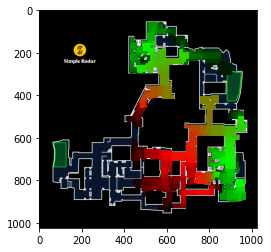

In [51]:
visIdx = 90
curF, curAx = plot_map_control_snapshot(curMapTile, tileValuesRound[visIdx][0], tileValuesRound[visIdx][1], map_name = 'de_inferno')



#### Generate Round Visualization GIF 

In [52]:
## create a temporary tmp folder where frames are going to be saved
## if you want a GIF of the round
    
# for i in range(len(tileValuesRound)):
#     if i % 10 == 0:
#         print(i, ' out of ', len(tileValuesRound))
#     curF, curAx = plot_map_control_snapshot(curMapTile, tileValuesRound[i][0], tileValuesRound[i][1], map_name = 'de_inferno')
#     plt.axis('off')   
#     curF.savefig(fname = './tmp/tmp_' + str(i) + '.png', bbox_inches='tight')
#     plt.close(curF)


0  out of  130
10  out of  130
20  out of  130
30  out of  130
40  out of  130
50  out of  130
60  out of  130
70  out of  130
80  out of  130
90  out of  130
100  out of  130
110  out of  130
120  out of  130


In [53]:
# with imageio.get_writer('FAZE-C9-Inferno-31.gif', mode='I') as writer:
#     for i in range(len(tileValuesRound)):
#         image = imageio.imread('./tmp/tmp_' + str(i) + '.png')
#         writer.append_data(image)


### Future Work

With the work I've done so far, I can see a lot of avenues for possible exploration. Here are some of ideas I've already collected (either from myself or from the CS:GO Discord)

- Core Metric Changes

    - The current method is based on the number of nav tiles along a path between a tile and a player's tile. This can be changed to game distance for more precise boundaries. Also, exact pixel locations could be used isntead of the nav tile locations, which are just a more coarse representation of the map's surfaces.
    - Tile value calculations are based on functions whose input was nav tile traversal length in this notebook. Changing this to pixel distance could have similar results as was stated above. Also, since we have the data on each player's weapon, we can estimate how long it should take a player to get to different areas on the map and use time as the input to the functions.
    - The previous bullet point mentioned weapons and linked it to the range of a player due to their player slowdown rates. Another way to change the current metric could be to represent the range/impact of a player on the map based on the current weapon and positioning on the map. For example, players with an AK might have a larger range than Deagle players, but the Deagle players might have "more impact" or "more control" in the short-range surrounding them compared to the AK players.
    - Incorporating sight lines into map control is a core component I want to do soon. I think this tweak paired with the bullet point above could be helpful in bringing meaning to the metric/experiments.

- Visualization
    - I think the visualizations are a bit confusing right now since it's hard to pinpoint where the teams specifically are. Plotting player positions on top of the current graphic is an easy fix I believe.
    
- Miscellaneous
    - Add support for more maps
    
These are just the ideas I have in attacking some of the probems. I'd love any suggestions/recommendations on these or other tweaks that could be made!
